#### This code builds and implements Neural Network models to predict pollution in Delhi using fire incidents in Punjab

In [151]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
#from utils import * 


In [283]:
sns.set_style('white') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('font', size=10)          # controls default text sizes

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 12
plt.rcParams["legend.frameon"] = False

#Choosing color palette

sns.color_palette('deep')
sns.color_palette('deep')[1]


(0.8666666666666667, 0.5176470588235295, 0.3215686274509804)

In [284]:
#Load cleaned data

work = pd.read_csv('working_ML.csv')

work = work.drop(columns = ['Unnamed: 0','incident_day', 'state_name', 
                                    'state_name_x_x', 
                                    'state_name_y_x', 'state_name_x_y', 'state_name_y_y', 
                                    'state_code','satellite_instrument'])


work['incident_dt'] = pd.to_datetime(work['incident_dt'])
work['incident_month'] = work['incident_dt'].dt.month
work['incident_yr'] = work['incident_dt'].dt.year
work['incident_week'] = work['incident_dt'].dt.isocalendar().week

#fill missing data
work['count_of_incidents'] = (work['count_of_incidents'].ffill() + work['count_of_incidents'].bfill())/2

#Drop post Covid observs

work = work.loc[work['incident_my'] <= '2020-02',:]

#one hot code the variables

work = pd.get_dummies(work, columns = ['incident_week'])

#Restrict to just peak fire activity months
work_peak = work.loc[work['incident_month'].isin([5,10,11]),]

work = pd.get_dummies(work, columns = ['incident_month'])
work_peak = pd.get_dummies(work_peak, columns = ['incident_month'])
#Pollution baseline

aod_mean_base = work.loc[work['incident_yr'] <= 2010,'stat'].mean()

aod_mean_base_peak = work_peak.loc[work_peak['incident_yr'] <= 2010,'stat'].mean()

#Only keep obs post 2012 (we are using VIIRS data)
work = work.loc[work['incident_dt'] >= '2012-01-21',]

work_peak = work_peak.loc[work_peak['incident_dt'] >= '2012-01-21',]


work = pd.get_dummies(work, columns = ['incident_yr'])

work_peak = pd.get_dummies(work_peak, columns = ['incident_yr'])

work['incident_month'] = work['incident_dt'].dt.month
work['incident_yr'] = work['incident_dt'].dt.year

#work.loc[work['aod_rescaled'] >= 3.0,'aod_rescaled'] = 3

work['aod_anomaly'] = work['stat'] - aod_mean_base

work_peak['aod_anomaly'] = work_peak['stat'] - aod_mean_base_peak

work_peak.columns

#change directory to output folder

os.chdir('/Users/abhishekdeshwal/Desktop/Homework/Sem III/Machine Learning/Final Project/output')


0.8960665064681562


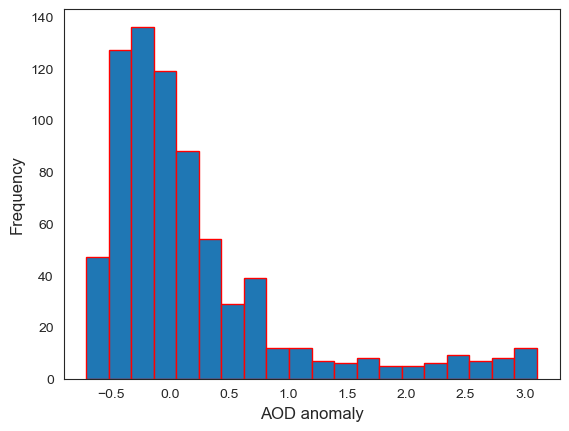

In [295]:
#Plot the distribution of aod anomaly

print(aod_mean_base_peak) #0.896 is the mean AOD 2000 to 2010

plt.hist(work_peak['aod_anomaly'], edgecolor = 'red', bins = 20)
plt.xlabel('AOD anomaly')
plt.ylabel('Frequency')
plt.savefig('hist_aod_anomaly.pdf', bbox_inches = 'tight')
plt.show()



In [285]:
#Only retain observations before Covid (external shock on pollution levels
#which the model doesn't account for)

#Peak period 
work = work.loc[work['incident_my'] <= '2020-02',:]
work_peak = work_peak.loc[work_peak['incident_my'] <= '2020-02',:]


In [286]:
work_peak.isna().sum() #no missing observations

incident_dt           0
stat                  0
count_of_incidents    0
incident_my           0
t2m_mean_del          0
                     ..
incident_yr_2016      0
incident_yr_2017      0
incident_yr_2018      0
incident_yr_2019      0
aod_anomaly           0
Length: 77, dtype: int64

In [287]:
work_peak

,incident_dt,stat,count_of_incidents,incident_my,t2m_mean_del,rainfall_mm_del,t2m_mean_punj,rainfall_mm_punj,wind_speed_del,wind_dir_del,...,incident_month_11,incident_yr_2012,incident_yr_2013,incident_yr_2014,incident_yr_2015,incident_yr_2016,incident_yr_2017,incident_yr_2018,incident_yr_2019,aod_anomaly
4448,2012-05-01,0.390669,115.0,2012-05,302.03820,0.000040,299.17825,0.241053,7.669854,3.472883,...,0,1,0,0,0,0,0,0,0,-0.505397
4449,2012-05-02,0.323567,180.0,2012-05,302.70135,0.000040,299.88544,0.014883,8.001947,337.454412,...,0,1,0,0,0,0,0,0,0,-0.572500
4450,2012-05-03,0.603852,158.0,2012-05,303.05103,0.002174,301.20364,0.070511,7.978336,319.722817,...,0,1,0,0,0,0,0,0,0,-0.292214
4451,2012-05-04,0.531049,134.0,2012-05,303.49414,0.000484,302.56384,0.029797,5.905530,329.776254,...,0,1,0,0,0,0,0,0,0,-0.365017
4452,2012-05-05,0.651722,125.0,2012-05,304.17490,0.000040,303.02640,0.008727,9.358280,104.909584,...,0,1,0,0,0,0,0,0,0,-0.244344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7213,2019-11-26,2.249796,4.0,2019-11,294.10706,0.110843,290.40130,2.824454,3.424297,30.944142,...,1,0,0,0,0,0,0,0,1,1.353729
7214,2019-11-27,1.955164,19.0,2019-11,293.30990,8.078305,290.49796,15.585099,2.105902,63.127237,...,1,0,0,0,0,0,0,0,1,1.059098
7215,2019-11-28,3.594842,4.0,2019-11,292.05350,13.014054,290.18988,6.677685,8.860424,79.224845,...,1,0,0,0,0,0,0,0,1,2.698775
7216,2019-11-29,1.021853,26.0,2019-11,291.27194,0.340689,289.63678,1.494106,3.790296,340.151093,...,1,0,0,0,0,0,0,0,1,0.125786


In [7]:
#Raw correlation between AOD and key predictors - maybe plot a scatter with linear fit

work[['count_of_incidents','aod_anomaly']].corr() #Correlation coeff of 0.33

work_peak[['count_of_incidents','aod_anomaly']].corr() #Correlation coeff of 0.44


,count_of_incidents,aod_anomaly
count_of_incidents,1.000000,0.449395
aod_anomaly,0.449395,1.000000


In [13]:
#Table that maybe shows the autocorrelation 
cc = work_peak[['count_of_incidents','aod_anomaly']]
cc['count_of_incidents'] = work_peak['count_of_incidents'].shift(3)
cc.head(10)
cc[['count_of_incidents','aod_anomaly']].corr() #Correlation coeff of 0.33

/var/folders/qy/t23x7wnj1llfk59xmchk96880000gn/T/ipykernel_21738/2845236444.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc['count_of_incidents'] = work_peak['count_of_incidents'].shift(3)


,count_of_incidents,aod_anomaly
count_of_incidents,1.000000,0.446474
aod_anomaly,0.446474,1.000000


# 1. Naive Neural Network (NN) for pollution prediction



In [15]:
work_peak.columns

Index(['incident_dt', 'stat', 'count_of_incidents', 'incident_my',
       't2m_mean_del', 'rainfall_mm_del', 't2m_mean_punj', 'rainfall_mm_punj',
       'wind_speed_del', 'wind_dir_del', 'wind_speed_punj', 'wind_dir_punj',
       'incident_week_1', 'incident_week_2', 'incident_week_3',
       'incident_week_4', 'incident_week_5', 'incident_week_6',
       'incident_week_7', 'incident_week_8', 'incident_week_9',
       'incident_week_10', 'incident_week_11', 'incident_week_12',
       'incident_week_13', 'incident_week_14', 'incident_week_15',
       'incident_week_16', 'incident_week_17', 'incident_week_18',
       'incident_week_19', 'incident_week_20', 'incident_week_21',
       'incident_week_22', 'incident_week_23', 'incident_week_24',
       'incident_week_25', 'incident_week_26', 'incident_week_27',
       'incident_week_28', 'incident_week_29', 'incident_week_30',
       'incident_week_31', 'incident_week_32', 'incident_week_33',
       'incident_week_34', 'incident_week_35', 'i

In [307]:
X_df_nn = work_peak.drop(columns = ['stat', 'aod_anomaly', 'incident_my'])

#standardizeation - normalize the predictors except for dummies

X_df_nn_nonDum = X_df_nn[['count_of_incidents', 't2m_mean_punj', 
             'rainfall_mm_punj', 'wind_speed_punj', 'wind_dir_punj', 'wind_speed_del', 
             'wind_dir_del', 't2m_mean_del', 'rainfall_mm_del']]

X_df_nn_Dum = X_df_nn.drop(columns = ['count_of_incidents', 't2m_mean_punj', 
             'rainfall_mm_punj', 'wind_speed_punj', 'wind_dir_punj', 'wind_speed_del', 
             'wind_dir_del', 't2m_mean_del', 'rainfall_mm_del'])

# Standardization - normalize the predictors

mean, std = X_df_nn_nonDum.mean(), X_df_nn_nonDum.std() #No need to normalize dummies

X_df_nn_nonDum   = (X_df_nn_nonDum - mean)/std

X_df = X_df_nn_Dum.join(X_df_nn_nonDum)

y = work_peak['aod_anomaly'].to_numpy()

X = X_df.to_numpy()

X.shape

(736, 74)

In [308]:
#Split into test and train datasets

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X[:,1:].astype(np.float32), y, test_size=0.30, random_state = 20221107)

print(X_train_nn.shape,y_train_nn.shape)

(515, 73) (515,)


In [309]:

X_train

array([[[Timestamp('2012-05-14 00:00:00'), 0, 0, ...,
         0.5079706501682594, 0.8013803983640119, -0.29433330804580193],
        [Timestamp('2012-05-15 00:00:00'), 0, 0, ...,
         0.6462149552345112, 0.9619807594488872, -0.3076439584672183],
        [Timestamp('2012-05-16 00:00:00'), 0, 0, ...,
         0.5214138500343691, 1.3314296491415953, -0.30746170160616637],
        [Timestamp('2012-05-17 00:00:00'), 0, 0, ..., 0.534917504823493,
         1.1933820309149077, -0.30746170160616637],
        [Timestamp('2012-05-18 00:00:00'), 0, 0, ...,
         0.6728442643877592, 1.1870491841407127, -0.3076439584672183]],

       [[Timestamp('2019-11-14 00:00:00'), 0, 0, ...,
         1.0566335524184858, -0.881866005046917, -0.30752559390133394],
        [Timestamp('2019-11-15 00:00:00'), 0, 0, ..., 0.920765646299089,
         -0.8517036459732539, -0.3076851826107981],
        [Timestamp('2019-11-16 00:00:00'), 0, 0, ...,
         0.8378708000145146, -0.7334230918237629, -0.3076851826107

### 1.1. Define the NN structure

In [30]:
#How to set hyperparameters?

activation     = 'relu'

#Define a function that creates the NN model

def nn_model(n_neuron = 64, activation = 'relu', learning_rate = 0.0001):
    # Model definition
    model = Sequential()

    model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train_nn.shape[1],))) #  the 1st hidden layer 
    model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
    model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
    model.add(Dense(n_neuron,  activation=activation)) # the 4th hidden layer
    model.add(Dense(1,  activation='linear')) # the output layer
    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate))

    return model

model = KerasRegressor(build_fn = nn_model, verbose = 0)    

#We perform search on minibatch_size, num_epochs and n_neuron

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)    
batch_size = [32, 64]
epochs = [300, 400, 500]
n_neuron = [64, 128]
learn_rate = [0.001, 0.0001]

fit_parameters = {'validation_split': 0.2, 
                    'verbose' : 0, 'callbacks': [early_stop]}

param_grid = dict(batch_size = batch_size, epochs = epochs, n_neuron = n_neuron, 
                  learning_rate = learn_rate)

grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(X_train_nn, y_train_nn, **fit_parameters)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

search_results_df = pd.DataFrame(grid_result.cv_results_)

/var/folders/qy/t23x7wnj1llfk59xmchk96880000gn/T/ipykernel_21738/1326647215.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn = nn_model, verbose = 0)
2022-12-19 18:41:50.043601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 18:41:50.043602: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the 

Best: -0.338214 using {'batch_size': 64, 'callbacks': <keras.callbacks.EarlyStopping object at 0x1adff2cb0>, 'epochs': 400, 'learning_rate': 0.0001, 'n_neuron': 128}


### 1.2 Pick the best model and perform predictions

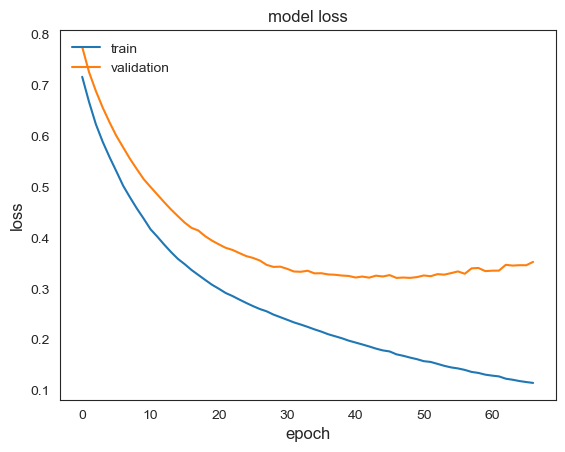

In [310]:
best_model = nn_model(n_neuron = 128, activation = 'relu', learning_rate = 0.0001)
history = best_model.fit(X_train_nn, y_train_nn, epochs = 400, batch_size = 64, verbose = 0, 
                         validation_split = 0.2, callbacks       = [early_stop])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('loss_lstm.png')
plt.show()

In [319]:

y_test_nn.shape

(221,)

7/7 [==============================] - 0s 1ms/step
RMS: 0.5290081928154975


/var/folders/qy/t23x7wnj1llfk59xmchk96880000gn/T/ipykernel_21738/1386485292.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(x = y_test_nn, y = y_test_nn_pred, label = 'NN', color = 'r',palette='Set2')


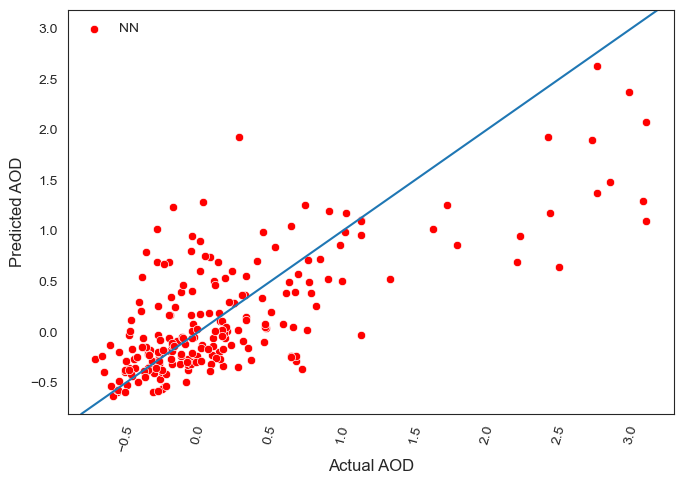

In [320]:
# Test the performance of the best model

y_test_nn_pred = best_model.predict(X_test_nn)
y_test_nn_pred = y_test_nn_pred.reshape(221,)
print("RMS: %s" % np.sqrt(np.mean((y_test_nn_pred - y_test_nn) ** 2)))

plt.figure(figsize=(7, 5), tight_layout=True)
ax = sns.scatterplot(x = y_test_nn, y = y_test_nn_pred, label = 'NN', color = 'r',palette='Set2')
ax.set(ylabel = 'Predicted AOD', xlabel = 'Actual AOD')
ax.axline((0,0),(3,3))    
plt.xticks(rotation = 75)
plt.savefig('fit_nn.pdf', bbox_inches = 'tight')
plt.show()

In [323]:
r2_score(y_test_nn,y_test_nn_pred) #very low R2 (0.55 R-sq)

0.5425083258047445

# LSTM Model

### 1. Define the LSTM Structure

In [299]:
l = 5 #lags
n = 5 #number of forward predictions
N = X.shape[0] # Total number of samples, 5 days ahead prediction with 5 lags

k = N - l - n
#k = N - l

# Create Input and output Slice
in_slice = np.array([range(i, i + l) for i in range(k)])
op_slice = np.array([range(i + l, i + l + n) for i in range(k)])

In [223]:
op_slice

array([[  7,   8,   9,  10,  11],
       [  8,   9,  10,  11,  12],
       [  9,  10,  11,  12,  13],
       ...,
       [728, 729, 730, 731, 732],
       [729, 730, 731, 732, 733],
       [730, 731, 732, 733, 734]])

In [300]:
X_lstm = X[in_slice,:]
print(X_lstm.shape)

(726, 5, 73)


In [301]:
y_lstm = y[op_slice]
print(y_lstm.shape)

(726, 5)


In [253]:
#Split the data into test and train

X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.30, 
                                                    random_state = 20221210)
#Omit the date vector. 

X_train_i = X_train[:,:,1:].astype(np.float32)
X_test_i = X_test[:,:,1:].astype(np.float32)

In [227]:
X_test[1,1,]

array([Timestamp('2014-10-30 00:00:00'), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1.636313509955227, -0.5359271853281917,
       -0.35417836081155013, 0.567500863870185, 0.9458284133084792,
       -0.5281745916035686, 1.0553598598003147, -0.29615066181064825,
       -0.2961097004881306], dtype=object)

### 2. Hypertuning of parameters with CV grid search

In [236]:
#Tune hyperparameters

activation     = 'relu'

#Define a function that creates the NN model

def lstm_model(n_neuron = 64, activation = 'relu', learning_rate = 0.0001):
    # Model definition
    lstm_model = Sequential()
    lstm_model.add(LSTM(n_neuron,input_shape=(X_train_i.shape[1],X_train_i.shape[2]),
                   return_sequences=True,activation=activation))
    lstm_model.add(LSTM(n_neuron,return_sequences=False,
                   activation=activation))
    lstm_model.add(Dense(n_neuron,activation=activation))
    lstm_model.add(Dense(5,activation='linear')) 

    lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    return lstm_model

model = KerasRegressor(build_fn = lstm_model, verbose = 0)    

#We perform search on minibatch_size, num_epochs and n_neuron

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)    
batch_size = [32, 64, 128]
epochs = [150, 200, 250]
n_neuron = [32, 64, 128]
learn_rate = [0.001, 0.0001]

fit_parameters = dict(validation_split = 0.2, 
                    verbose = 0, shuffle = False,
                 callbacks =  [early_stop])

param_grid = dict(batch_size = batch_size, epochs = epochs, n_neuron = n_neuron, 
                  learning_rate = learn_rate)

grid = GridSearchCV(estimator = model, param_grid = param_grid, 
                    scoring='neg_mean_squared_error', n_jobs = -1, cv = 3)

grid_result = grid.fit(X_train_i, y_train, **fit_parameters)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

search_results_df = pd.DataFrame(grid_result.cv_results_)

/var/folders/qy/t23x7wnj1llfk59xmchk96880000gn/T/ipykernel_21738/1816056581.py:21: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn = lstm_model, verbose = 0)
/Users/abhishekdeshwal/opt/anaconda3/envs/keras/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2022-12-22 01:18:59.684926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 01:20:05.945597: I te

Best: -0.336547 using {'batch_size': 32, 'epochs': 150, 'learning_rate': 0.0001, 'n_neuron': 128}


In [324]:
search_results_df['rmse'] = -search_results_df['mean_test_score']
search_results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_batch_size', 'param_epochs', 'param_learning_rate',
       'param_n_neuron', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'rmse'],
      dtype='object')

### 3. Pick the best model and perform predictions

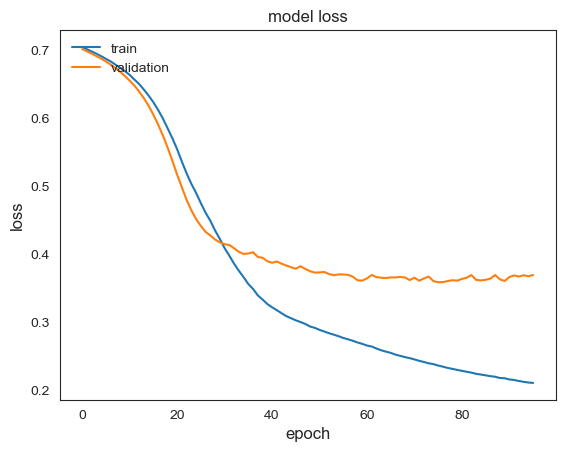

In [256]:
best_model_lstm = lstm_model(n_neuron = 64, activation = 'relu', learning_rate = 0.0001)
history = best_model_lstm.fit(X_train_i, y_train, epochs = 150, batch_size = 64, verbose = 0, 
                         validation_split = 0.2, shuffle = True, callbacks       = [early_stop])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('loss_lstm.png')
plt.show()

7/7 [==============================] - 0s 2ms/step
RMS: test 0.5161045352833814


/var/folders/qy/t23x7wnj1llfk59xmchk96880000gn/T/ipykernel_21738/2608118122.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot( x = y_test[:,0], y = y_test_pred[:,0], label = 'LSTM', color = 'r',palette='Set2')


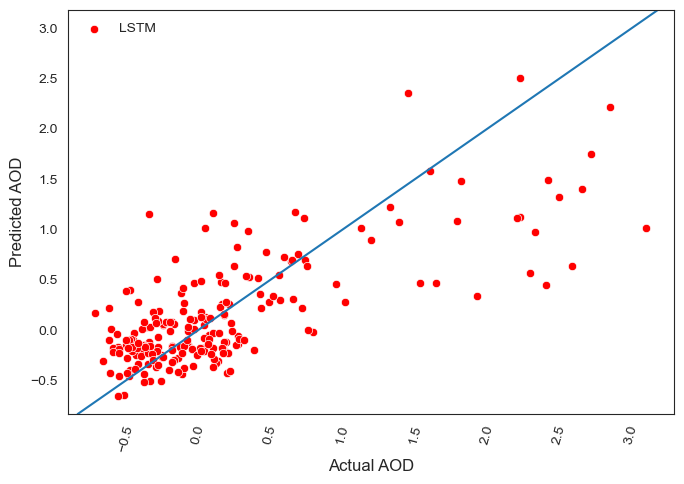

0.5503891992710415


In [322]:
y_test_pred = best_model_lstm.predict(X_test_i)

print("RMS: test %s" % np.sqrt(np.mean((y_test_pred[:,0] - y_test[:,0]) ** 2)))
plt.figure(figsize=(7, 5), tight_layout=True)
ax = sns.scatterplot( x = y_test[:,0], y = y_test_pred[:,0], label = 'LSTM', color = 'r',palette='Set2')
ax.set(ylabel = 'Predicted AOD', xlabel = 'Actual AOD')
ax.axline((0,0),(3,3))    
plt.xticks(rotation = 75)
plt.savefig('fit_lstm_fr1.pdf', bbox_inches = 'tight')
plt.show()
print(r2_score(y_test[:,0],y_test_pred[:,0])) #Decent R-sqaured  #0.52 (because of shuffling?)



## Sensitivity of MSE to hyperparameters

/var/folders/qy/t23x7wnj1llfk59xmchk96880000gn/T/ipykernel_21738/83722023.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = search_results_df.loc[(search_results_df['param_learning_rate'] == 0.001) & (search_results_df['param_epochs'] == 150) &
/var/folders/qy/t23x7wnj1llfk59xmchk96880000gn/T/ipykernel_21738/83722023.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = search_results_df.loc[(search_results_df['param_learning_rate'] == 0.0001) & (search_results_df['param_epochs'] == 150) &
/var/folders/qy/t23x7wnj1llfk59xmchk96880000gn/T/ipykernel_21738/83722023.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = search_results_df.loc[(search_results_df['param_learning_rate'] == 0.001) & (search_results_df['param_epochs'] == 150) &
/var/folders/qy/t23x7wnj1llfk59xmchk96880000gn/T/ipykernel_21738/83722023.py:10: UserWarning: Ignor

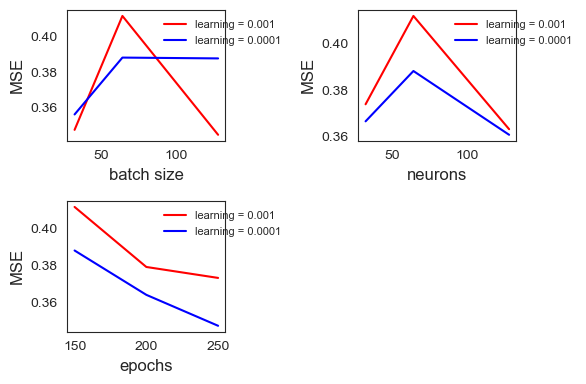

In [353]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(6, 4), tight_layout=True)
sns.lineplot(data = search_results_df.loc[(search_results_df['param_learning_rate'] == 0.001) & (search_results_df['param_epochs'] == 150) & 
                                             (search_results_df['param_n_neuron'] == 64), :], x = 'param_batch_size', y = 'rmse', label = 'learning = 0.001', color = 'r',palette='Set2', ax = ax[0,0])
sns.lineplot(data = search_results_df.loc[(search_results_df['param_learning_rate'] == 0.0001) & (search_results_df['param_epochs'] == 150) & 
                                             (search_results_df['param_n_neuron'] == 64), :], x = 'param_batch_size', y = 'rmse', label = 'learning = 0.0001', color = 'b',palette='Set2', ax = ax[0,0])
ax[0,0].legend(fontsize = 8,bbox_to_anchor=(0.55, 1.0), loc="upper left")
ax[0,0].set(xlabel = "batch size", ylabel = "MSE")
sns.lineplot(data = search_results_df.loc[(search_results_df['param_learning_rate'] == 0.001) & (search_results_df['param_epochs'] == 150) & 
                                             (search_results_df['param_batch_size'] == 64), :], x = 'param_n_neuron', y = 'rmse', label = 'learning = 0.001', color = 'r',palette='Set2', ax = ax[0,1])
sns.lineplot(data = search_results_df.loc[(search_results_df['param_learning_rate'] == 0.0001) & (search_results_df['param_epochs'] == 150) & 
                                             (search_results_df['param_batch_size'] == 64), :], x = 'param_n_neuron', y = 'rmse', label = 'learning = 0.0001', color = 'b',palette='Set2', ax = ax[0,1])
ax[0,1].legend(fontsize = 8,bbox_to_anchor=(0.55, 1.0), loc="upper left")
ax[0,1].set(xlabel = "neurons", ylabel = "MSE")
sns.lineplot(data = search_results_df.loc[(search_results_df['param_learning_rate'] == 0.001) & (search_results_df['param_n_neuron'] == 64) & 
                                             (search_results_df['param_batch_size'] == 64), :], x = 'param_epochs', y = 'rmse', label = 'learning = 0.001', color = 'r',palette='Set2', ax = ax[1,0])
sns.lineplot(data = search_results_df.loc[(search_results_df['param_learning_rate'] == 0.0001) & (search_results_df['param_n_neuron'] == 64) & 
                                             (search_results_df['param_batch_size'] == 64), :], x = 'param_epochs', y = 'rmse', label = 'learning = 0.0001', color = 'b',palette='Set2', ax = ax[1,0])
ax[1,0].legend(fontsize = 8,bbox_to_anchor=(0.55, 1.0), loc="upper left")
ax[1,0].set(xlabel = "epochs", ylabel = "MSE")
fig.delaxes(ax[1][1])
plt.savefig('sensitivity_hyperparameters.pdf', bbox_inches = 'tight')
plt.show()

## Forecast Performance

In [354]:
#generate MSE andd R2 corresponding to each forward
summary_frw_lstm = np.zeros((5,3))
for i in range(5):
    summary_frw_lstm[i, 0] = i
    summary_frw_lstm[i, 1] = np.sqrt(np.mean((y_test_pred[:,i] - y_test[:,i]) ** 2))
    summary_frw_lstm[i, 2] = r2_score(y_test[:,i],y_test_pred[:,i])
    
#Convert to pandas and plot

summary_frw_lstm_pd = pd.DataFrame(summary_frw_lstm, columns = ['forward_period', 'RMSE', 'R2'])
summary_frw_lstm_pd

,forward_period,RMSE,R2
0,0.0,0.516105,0.550389
1,1.0,0.520517,0.507204
2,2.0,0.550295,0.544678
3,3.0,0.505171,0.537069
4,4.0,0.561871,0.517234


## Construct a time series of results

In [355]:
y_join = np.concatenate((y_test, y_test_pred), axis = 1)
y_join = pd.DataFrame(y_join, columns = ['y_test1','y_test2', 'y_test3', 'y_test4', 'y_test5',
                                         'y_pred1', 'y_pred2', 'y_pred3', 'y_pred4', 'y_pred5'])
test_dt = pd.DataFrame(X_test[:,1,0], columns = ['incident_dt'])
df = test_dt.join(y_join)

df['incident_dt'] = pd.to_datetime(df['incident_dt'])

df = df.sort_values(by = 'incident_dt')

df.shape

(218, 11)

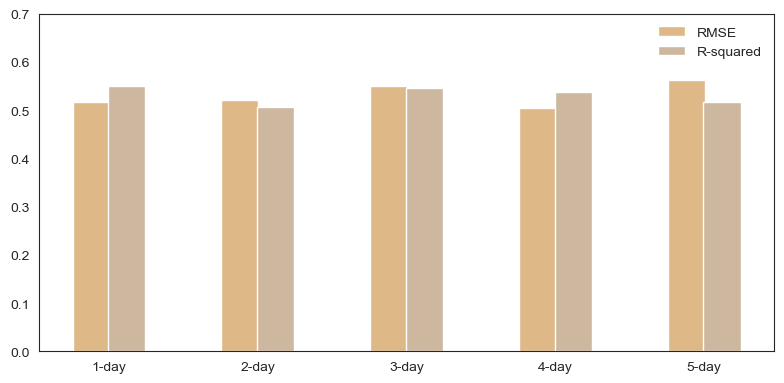

In [356]:
#Bar graph comparing performance across forwards
plt.figure(figsize=(8,4), tight_layout=True)
x = np.arange(5)
labels = ['1-day', '2-day', '3-day', '4-day', '5-day']
width = 0.25

###### RMSE #######

plt.bar(x - 0.12, summary_frw_lstm_pd.loc[:,'RMSE'], width, color='#DEB887', label = 'RMSE')
plt.bar(x + 0.12, summary_frw_lstm_pd.loc[:,'R2'], width, color='#CDB79E', label = 'R-squared')
plt.legend()
plt.xticks(x, labels)
plt.ylim(0, 0.7)
plt.savefig('summary_stats_by_forwards.pdf', bbox_inches = 'tight')
plt.show()


/var/folders/qy/t23x7wnj1llfk59xmchk96880000gn/T/ipykernel_21738/405066820.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df.loc[(df['incident_dt'] >= '2019-10-01') & (df['incident_dt'] <= '2019-11-30'),:], x = 'incident_dt', y = 'y_test5', label = 'Actual', color = 'g',palette='Set2', ax = ax1)
/var/folders/qy/t23x7wnj1llfk59xmchk96880000gn/T/ipykernel_21738/405066820.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df.loc[(df['incident_dt'] >= '2019-10-01') & (df['incident_dt'] <= '2019-11-30'),:], x = 'incident_dt', y = 'y_pred5', label = 'Predicted', color = 'y', palette='Set2', ax = ax1)
/var/folders/qy/t23x7wnj1llfk59xmchk96880000gn/T/ipykernel_21738/405066820.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df.loc[(df['incident_dt'] >= '2018-10-01') & (df['incident_dt'] <= '2018-11-30'),:], x = 'incident_dt', y 

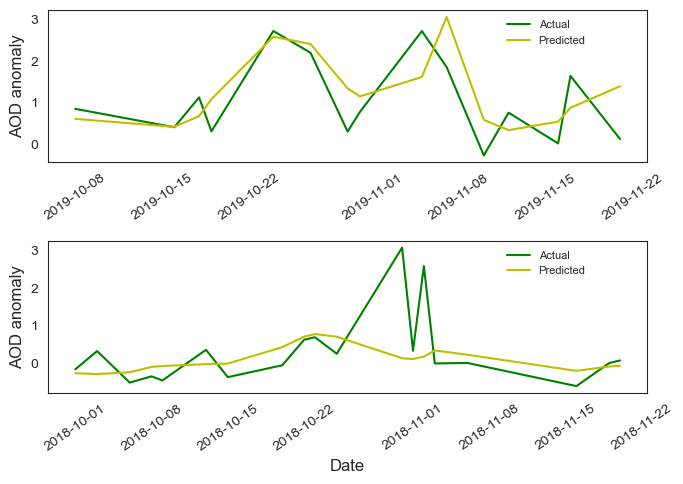

In [372]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 5), tight_layout=True)

sns.lineplot(data = df.loc[(df['incident_dt'] >= '2019-10-01') & (df['incident_dt'] <= '2019-11-30'),:], x = 'incident_dt', y = 'y_test5', label = 'Actual', color = 'g',palette='Set2', ax = ax1)
sns.lineplot(data = df.loc[(df['incident_dt'] >= '2019-10-01') & (df['incident_dt'] <= '2019-11-30'),:], x = 'incident_dt', y = 'y_pred5', label = 'Predicted', color = 'y', palette='Set2', ax = ax1)
ax1.set(ylabel = 'AOD anomaly', xlabel = '')
ax1.legend(fontsize = 8, bbox_to_anchor = (0.75, 1.0), loc="upper left")
ax1.tick_params(axis='x', rotation=35)

sns.lineplot(data = df.loc[(df['incident_dt'] >= '2018-10-01') & (df['incident_dt'] <= '2018-11-30'),:], x = 'incident_dt', y = 'y_test5', label = 'Actual', color = 'g',palette='Set2', ax = ax2)
sns.lineplot(data = df.loc[(df['incident_dt'] >= '2018-10-01') & (df['incident_dt'] <= '2018-11-30'),:], x = 'incident_dt', y = 'y_pred5', label = 'Predicted', color = 'y', palette='Set2', ax = ax2)
ax2.set(ylabel = 'AOD anomaly', xlabel = 'Date')
ax2.legend(fontsize = 8,bbox_to_anchor=(0.75, 1.0), loc="upper left")
plt.xticks(rotation = 35)
plt.savefig('predicted_lstm_timeline_kharif.pdf', bbox_inches = 'tight')
plt.show()


/var/folders/qy/t23x7wnj1llfk59xmchk96880000gn/T/ipykernel_21738/4006530047.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df.loc[(df['incident_dt'] >= '2019-05-01') & (df['incident_dt'] <= '2019-05-31'),:], x = 'incident_dt', y = 'y_test5', label = 'Actual', color = 'g',palette='Set2', ax = ax1)
/var/folders/qy/t23x7wnj1llfk59xmchk96880000gn/T/ipykernel_21738/4006530047.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df.loc[(df['incident_dt'] >= '2019-05-01') & (df['incident_dt'] <= '2019-05-31'),:], x = 'incident_dt', y = 'y_pred5', label = 'Predicted', color = 'y', palette='Set2', ax = ax1)
/var/folders/qy/t23x7wnj1llfk59xmchk96880000gn/T/ipykernel_21738/4006530047.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df.loc[(df['incident_dt'] >= '2018-05-01') & (df['incident_dt'] <= '2018-05-31'),:], x = 'incident_dt'

<Figure size 640x480 with 0 Axes>

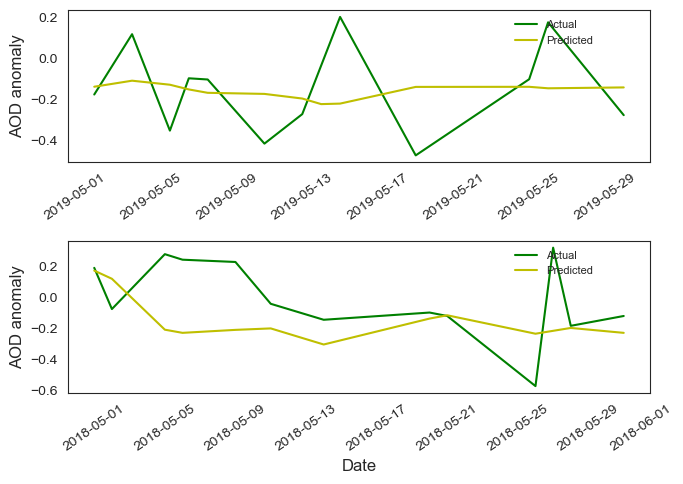

In [371]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 5), tight_layout=True)

sns.lineplot(data = df.loc[(df['incident_dt'] >= '2019-05-01') & (df['incident_dt'] <= '2019-05-31'),:], x = 'incident_dt', y = 'y_test5', label = 'Actual', color = 'g',palette='Set2', ax = ax1)
sns.lineplot(data = df.loc[(df['incident_dt'] >= '2019-05-01') & (df['incident_dt'] <= '2019-05-31'),:], x = 'incident_dt', y = 'y_pred5', label = 'Predicted', color = 'y', palette='Set2', ax = ax1)
ax1.set(ylabel = 'AOD anomaly', xlabel = '')
ax1.legend(fontsize = 8, bbox_to_anchor = (0.75, 1.0), loc="upper left")
plt.xticks(rotation = 75)
ax1.tick_params(axis='x', rotation=35)

sns.lineplot(data = df.loc[(df['incident_dt'] >= '2018-05-01') & (df['incident_dt'] <= '2018-05-31'),:], x = 'incident_dt', y = 'y_test5', label = 'Actual', color = 'g',palette='Set2', ax = ax2)
sns.lineplot(data = df.loc[(df['incident_dt'] >= '2018-05-01') & (df['incident_dt'] <= '2018-05-31'),:], x = 'incident_dt', y = 'y_pred5', label = 'Predicted', color = 'y', palette='Set2', ax = ax2)
ax2.set(ylabel = 'AOD anomaly', xlabel = 'Date')
ax2.legend(fontsize = 8,bbox_to_anchor=(0.75, 1.0), loc="upper left")
plt.xticks(rotation = 35)
plt.savefig('predicted_lstm_timeline_rabi.pdf', bbox_inches = 'tight')
plt.show()

